In [105]:
# based on https://www.cs.colostate.edu/eeg/data/json/doc/tutorial/_build/html/getting_started.html#downloading-eeg-data

import json
import numpy as np
import matplotlib.pyplot as plt

data = json.load(open('..\\..\\data\\s20-gammasys-gifford-unimpaired.json','r'))

In [106]:
print(len(data))
data[0].keys()

8


dict_keys(['protocol', 'sample rate', 'notes', 'channels', 'device', 'location', 'date', 'eeg', 'impairment', 'subject'])

(9, 46330)
[[ 25.997  15.354  26.112 ...  23.708  17.242  15.45 ]
 [ 14.286   1.183   9.46  ...  16.003  10.109   4.787]
 [ 38.071  26.684  37.06  ...  30.632  30.136  26.321]
 ...
 [ -2.918 -16.613   0.42  ...  -3.872  -9.766  -9.193]
 [  2.689  -9.632  12.589 ...  20.504  17.3    20.847]
 [  0.      0.      0.    ... -43.      0.      0.   ]]


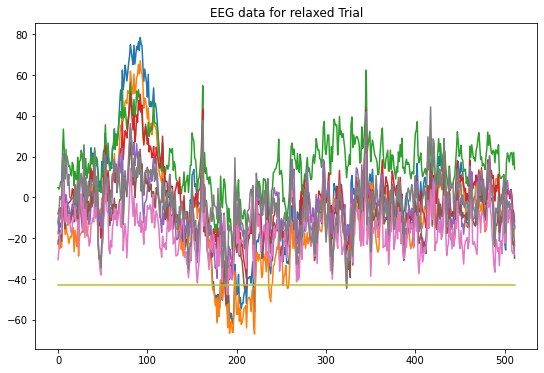

In [108]:
#3 minutes of EEG recorded while the subject was asked to relax and look at the computer screen (2 seconds of this data)
#data from all 9 channels for columns 1,000 to 1,512

first = data[0]

eeg = np.array(first['eeg']['trial 1'])
print(eeg.shape)
print(eeg)

plt.figure(1);
plt.plot(eeg[:,4000:4512].T); #[:,4000:4512] : is X, 4000:4512 is part of Y 
plt.title('EEG data for relaxed Trial')
plt.axis('tight'); 

Text(0.5, 1.0, 'EEG Spread Out')

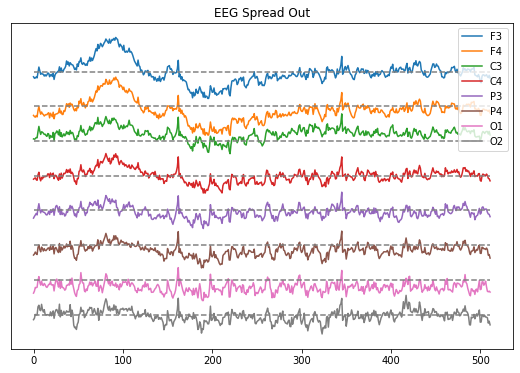

In [109]:
#Spread out data and remove unused 9th channel

plt.figure(2);

plt.plot(eeg[:8,4000:4512].T + 80*np.arange(7,-1,-1));

plt.plot(np.zeros((512,8)) + 80*np.arange(7,-1,-1),'--',color='gray');

plt.yticks([]);

plt.legend(first['channels']);

plt.axis('tight');

plt.title('EEG Spread Out')

In [68]:
#Summarize data

dataGammasys = data

dataActivetwo = json.load(open('..\\..\\data\\s20-activetwo-gifford-unimpaired.json','r'))

dataMindset = json.load(open('..\\..\\data\\s20-mindset-gifford-unimpaired.json','r'))


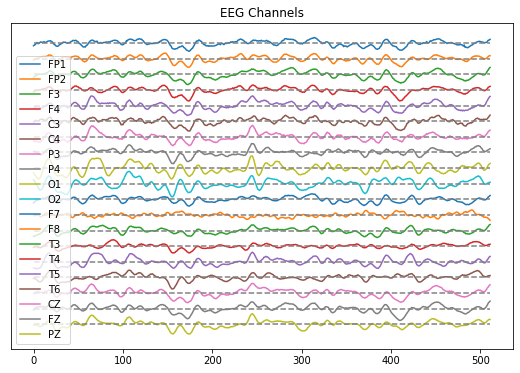

In [110]:
#Plot of first 19 rows (EEG Data)

eegMindset = np.array(dataMindset[0]['eeg']['trial 1'])

plt.figure();

plt.plot(eegMindset[:19,4000:4512].T + 30*np.arange(18,-1,-1));

plt.plot(np.zeros((512,19)) + 30*np.arange(18,-1,-1),'--',color='gray');

plt.yticks([]);

plt.rcParams["figure.figsize"] = (9,6)

plt.legend(dataMindset[0]['channels'], prop={'size':10});

plt.title('EEG Channels')

plt.axis('tight');

In [70]:
eegActivetwo = np.array(dataActivetwo[1]['eeg']['trial 1'])

eegActivetwo.shape

(41, 185344)

In [71]:
#removing the linear trend
import scipy.signal as sig

eegActivetwo = sig.detrend(eegActivetwo,1)

ref = np.mean(eegActivetwo[36:38,:],axis=0).reshape((1,-1))

eeg = eegActivetwo[:32,:] - ref

Text(0.5, 1.0, '32 EEG channels')

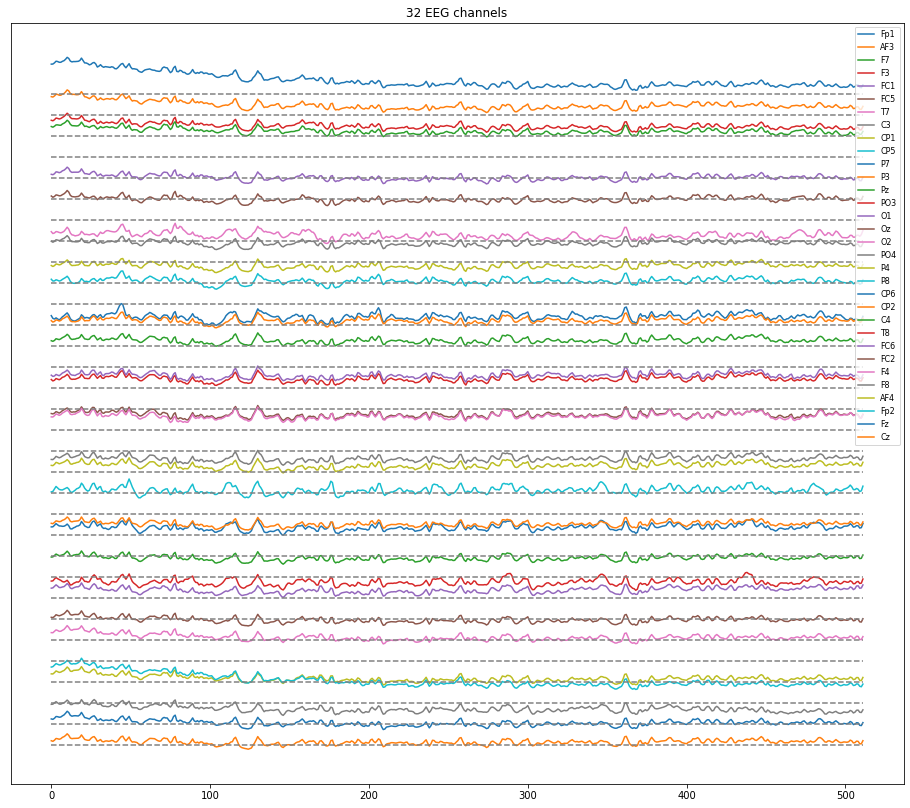

In [72]:
#Plot all 32 EEG channels

f = plt.figure();

plt.plot(eeg[:,4000:4512].T + 150*np.arange(31,-1,-1));

plt.plot(np.zeros((512,32)) + 150*np.arange(31,-1,-1),'--',color='gray');

plt.yticks([]);

plt.legend(dataActivetwo[0]['channels'][:32], prop={'size':8});

f.set_figwidth(16)
f.set_figheight(14)

plt.axis('tight');

plt.title('32 EEG channels')

In [73]:
#bandpass.py from ObsPy = function: bandpass. Used to pass frequencies from 1 to 30 Hz 

def bandpass(data, freqmin, freqmax, df, corners=4, zerophase=True, axis=-1):
    """
    Butterworth-Bandpass Filter.
    Filter data, with time progressing down the rows, from freqmin to freqmax using
    corners corners.
    :param data: Data to filter, type numpy.ndarray.
    :param freqmin: Pass band low corner frequency.
    :param freqmax: Pass band high corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners. Note: This is twice the value of PITSA's
        filter sections
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the number of corners but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.

    From http://obspy.org
    """
    fe = 0.5 * df
    low = freqmin / fe
    high = freqmax / fe
    # raise for some bad scenarios
    if high > 1:
        high = 1.0
        msg = "Selected high corner frequency is above Nyquist. " + \
              "Setting Nyquist as high corner."
        import warnings
        warnings.warn(msg)
    if low > 1:
        msg = "Selected low corner frequency is above Nyquist."
        raise ValueError(msg)
    [b, a] = sig.iirfilter(corners, [low, high], btype='band',
                           ftype='butter', output='ba')
    filtered = sig.lfilter(b, a, data, axis=axis)
    if zerophase:
        axisReversed = [slice(None),] * filtered.ndim
        axisReversed[axis] = slice(None,None,-1)
        filtered = sig.lfilter(b,a,filtered[axisReversed])[axisReversed]
    return filtered

<ipython-input-73-48fc8e7979ad>:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  filtered = sig.lfilter(b,a,filtered[axisReversed])[axisReversed]


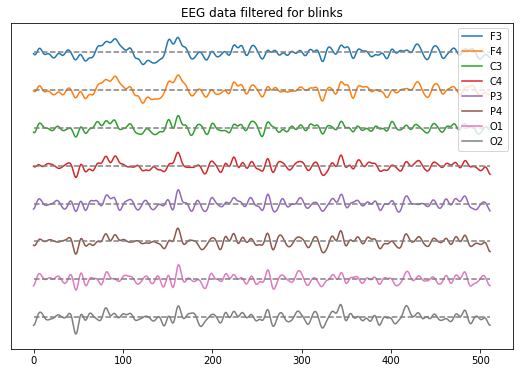

In [111]:
#Filter data to remove blink artifacts around sample 100

data = json.load(open('..\\..\\data\\s20-gammasys-gifford-unimpaired.json','r'))

first = data[0]

eeg = np.array(first['eeg']['trial 1'])

filtered =  bandpass(eeg[:8,:], 2,30, 256, corners=5, zerophase=True, axis=1)

plt.figure(3);

plt.plot(filtered[:8,4000:4512].T + 80*np.arange(7,-1,-1));

plt.plot(np.zeros((512,8)) + 80*np.arange(7,-1,-1),'--',color='gray');

plt.title('EEG data filtered for blinks')

plt.yticks([]);

plt.axis('tight');

plt.legend(first['channels']);

<Figure size 648x432 with 0 Axes>

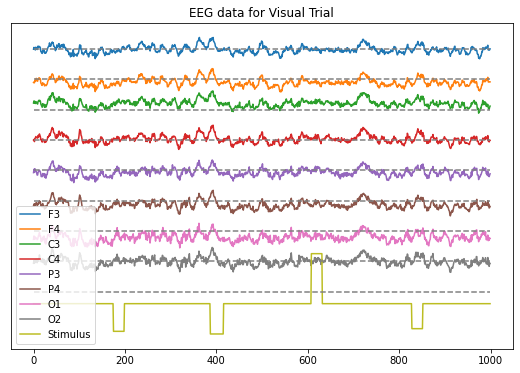

In [112]:
#EEG taken during visusal task
#subjects looked at a computer screen and letters were shown in a random order at the center
#subjects were asked to count the frequency of specific letters to elicit P300

f=plt.figure()

data = json.load(open('..\\..\\data\\s21-gammasys-gifford-unimpaired.json','r'))

letterd = data[4]

letterd['protocol']
u'letter-d'

# Note the transpose here.  Time now advances by row.  Columns are channels
eeg = np.array(letterd['eeg']['trial 1']).T

plt.ion()

plt.figure();

plt.plot(eeg[4000:5000,:9] + 80*np.arange(8,-1,-1));

plt.plot(np.zeros((1000,9)) + 80*np.arange(8,-1,-1),'--',color='gray');

plt.yticks([]);

plt.rcParams["figure.figsize"] = (9,6)

plt.title('EEG data for Visual Trial')

plt.legend(letterd['channels'] + ['Stimulus']);

plt.axis('tight');

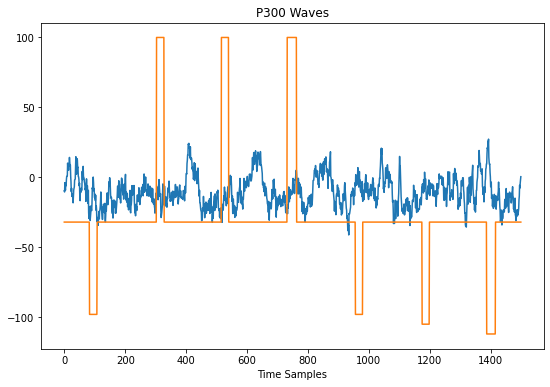

In [113]:
#data from the stimulus channel (index 8) and Channel P3 (index 5) to show presence or absence of P300 waves.

plt.clf();

plt.plot(eeg[3000:4500,[5,8]]);

plt.axis('tight');

plt.title('P300 Waves')

plt.xlabel('Time Samples');

In [93]:
#‘d’ trial: sample indices(start of stimuli), displayed letters for the stimulus, and stimuli that are the target letter.

starts = np.where(np.diff(np.abs(eeg[:,-1])) > 0)[0]

stimuli = [chr(int(n)) for n in np.abs(eeg[starts+1,-1])]

targetLetter = letterd['protocol'][-1]

targetSegments = np.array(stimuli) == targetLetter

len(starts),len(stimuli),len(targetSegments)
(80, 80, 80)

for i,(s,stim,targ) in enumerate(zip(starts,stimuli,targetSegments)):
    print(s,stim,targ,end=" ; ", flush=True)
    if (i+1) % 5 == 0:
        print

247 b False ; 465 a False ; 683 p False ; 899 d True ; 1119 p False ; 1337 b False ; 1551 p False ; 1771 d True ; 1985 b False ; 2207 b False ; 2427 n False ; 2643 v False ; 2863 d True ; 3082 b False ; 3302 d True ; 3515 d True ; 3731 d True ; 3955 b False ; 4174 i False ; 4386 p False ; 4607 d True ; 4827 b False ; 5043 b False ; 5262 a False ; 5482 p False ; 5695 p False ; 5919 d True ; 6135 d True ; 6351 d True ; 6567 b False ; 6787 t False ; 7007 b False ; 7223 d True ; 7443 d True ; 7659 t False ; 7879 d True ; 8095 p False ; 8317 p False ; 8533 s False ; 8749 p False ; 8971 b False ; 9187 d True ; 9402 p False ; 9626 s False ; 9843 b False ; 10059 m False ; 10275 i False ; 10495 m False ; 10711 p False ; 10930 p False ; 11147 p False ; 11367 b False ; 11583 d True ; 11805 k False ; 12023 p False ; 12235 p False ; 12458 p False ; 12679 b False ; 12893 d True ; 13109 d True ; 13333 v False ; 13551 f False ; 13770 n False ; 13987 d True ; 14202 f False ; 14418 e False ; 14635 k Fal

In [96]:
#number of samples between each stimulus onset (lenght of each time window)

np.diff(starts)

array([218, 218, 216, 220, 218, 214, 220, 214, 222, 220, 216, 220, 219,
       220, 213, 216, 224, 219, 212, 221, 220, 216, 219, 220, 213, 224,
       216, 216, 216, 220, 220, 216, 220, 216, 220, 216, 222, 216, 216,
       222, 216, 215, 224, 217, 216, 216, 220, 216, 219, 217, 220, 216,
       222, 218, 212, 223, 221, 214, 216, 224, 218, 219, 217, 215, 216,
       217, 220, 220, 215, 224, 217, 214, 217, 220, 217, 219, 224, 216,
       217], dtype=int64)

In [97]:
#minimum number

np.min(np.diff(starts))

212

In [98]:
#matrix with rows being segments, and each row being all indices for that segment, (time windows of 210 samples)

indices = np.array([ np.arange(s,s+210) for s in starts ])

indices.shape

(80, 210)

In [99]:
#80 x 210 x 8 array of segments.

segments = eeg[indices,:8]

In [2]: segments.shape

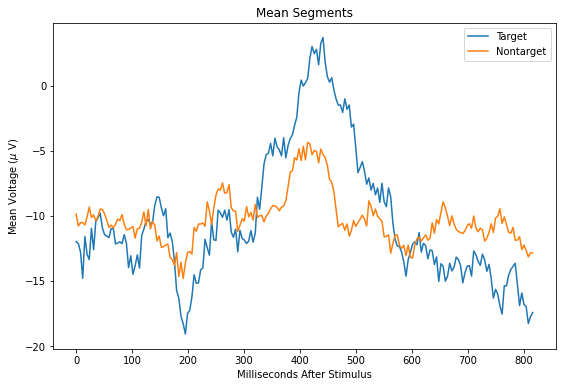

In [114]:
#average all target segments and nontarget segments for the P4 channel (index 5), and plot two resulting mean segments.
#segments are averaged to minimize the effect of variations across multiple stimuli and emphasize the parts of the signal that are common to the stimuli

segments[targetSegments,:,5].shape


targetMean = np.mean(segments[targetSegments,:,5],axis=0)

nontargetMean = np.mean(segments[targetSegments==False,:,5],axis=0)

plt.clf();

xs = np.arange(len(targetMean)) / 256.0 * 1000  # milliseconds

plt.plot(xs, np.vstack((targetMean,nontargetMean)).T);

plt.legend(('Target','Nontarget'));

plt.axis('tight');

plt.title('Mean Segments')

plt.xlabel('Milliseconds After Stimulus');

plt.ylabel('Mean Voltage ($\mu$ V)');